In [14]:
VAL_SIZE = .2
SEED = 42

# Split the dev set into train and validation sets

- load data

In [2]:
import pandas as pd
import sys
import ipyplot
sys.path.append("../src/")
from utils import *

# load no_issue_samples dataframe from csv
data = pd.read_csv('./datasets/FHI2020_Stratified_Sampling/dev_set.csv')

print(f"Total of images on the dev set: {len(data)}")


Total of images on the dev set: 6778


- Function to split the dev set into train and validation sets.

In [3]:
# Split the data into train and validation sets
from sklearn.model_selection import GroupShuffleSplit


# Get the unique sample names and quantities
def split_data(data, test_size=.2, random_state=42):
    """
    Split the data into train and validation sets
    """
    # I'll split based on 'sample_id' to ensure images of the same card stay together
    # Assuming 'group' here would represent the combined 'sample_name' and 'quantity' for stratification
    
    
    ## List of medicines (APIs) and  quantities
    sample_names = data.sample_name.unique()
    quantities = data.quantity.unique()

    # Initialize the splitter
    splitter = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=random_state)
    
    # Initialize the lists to store the indexes of the training and test sets
    all_train_idx = []
    all_test_idx = []
    
    for sample_name in sample_names:
        for quantity in quantities:
            #rint(f"\n{sample_name}\t{quantity}")
            subset = data[(data['sample_name'] == sample_name) & (data['quantity'] == quantity)]
       
            # Perform the split
            for train_idx, test_idx in splitter.split(subset, groups=subset['sample_id']):
                train_subset = subset.iloc[train_idx]
                test_subset = subset.iloc[test_idx]

                # append these subsets to the overall training and testing set indexes
                all_train_idx += train_subset.index.tolist()
                all_test_idx += test_subset.index.tolist()
                #print(f"train {len(train_idx)} test {len(test_idx)}")
                
    test_df = data.iloc[all_test_idx]
    train_df = data.iloc[all_train_idx]
    
    return train_df, test_df


- Splitting the dev set into train and validation sets.

In [4]:
train, val = split_data(data, test_size=VAL_SIZE, random_state=SEED)

## See the distribution of data after the splitting

In [5]:
# order medicines names: medicine by unique samples
samples_unique = train[['sample_id','sample_name']].value_counts().reset_index(name='counts')
samples_unique_grp = samples_unique.groupby(['sample_name']).size().reset_index(name='counts')
unique_class_counter = samples_unique_grp.sort_values(by=['counts'], ascending=False).reset_index(drop=True)
rows_order = unique_class_counter.sample_name.tolist() # set_df.sample_name.unique() 

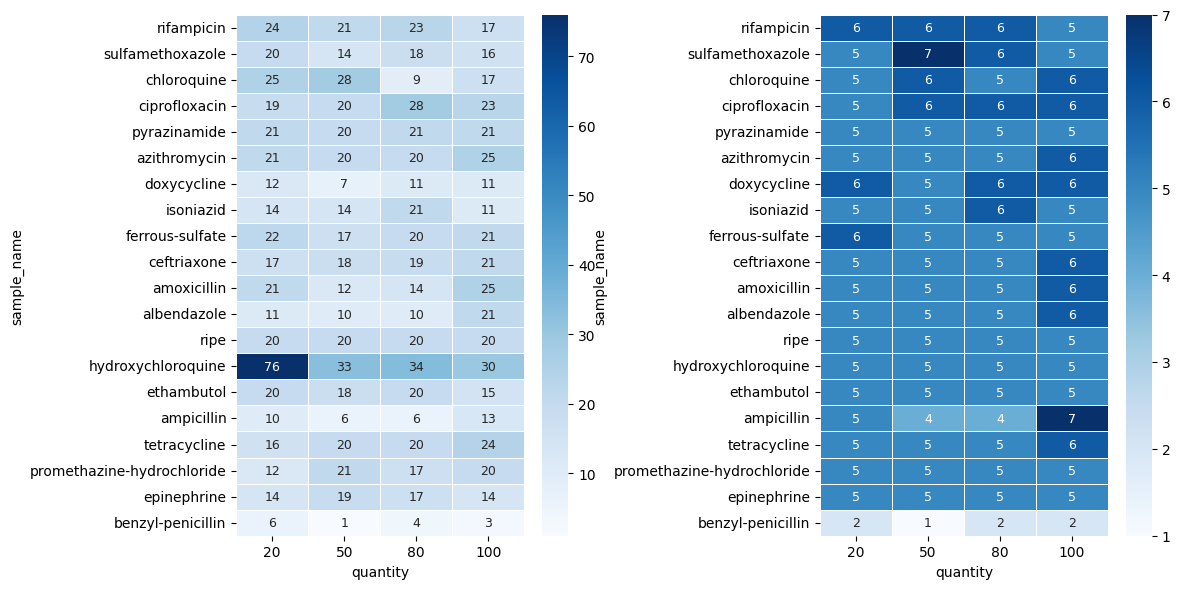

In [9]:
set_df = val
samples_unique = set_df[['sample_id','sample_name','quantity']].value_counts().reset_index(name='counts')
df1 = samples_unique[['sample_name','quantity']].value_counts().reset_index(name='counts')
df2 = set_df[['sample_name','quantity']].value_counts().reset_index(name='counts')

rows = "sample_name"
cols = "quantity"
values = "counts"

table1 = get_heatmap_table(df1, rows, cols, values, rows_order)
table2 = get_heatmap_table(df2, rows, cols, values, rows_order)
show_heatmap_tables(table2, table1, save_name= "./datasets/FHI2020_Stratified_Sampling/report/val_set_heatmap.png", figsize=(12, 6))

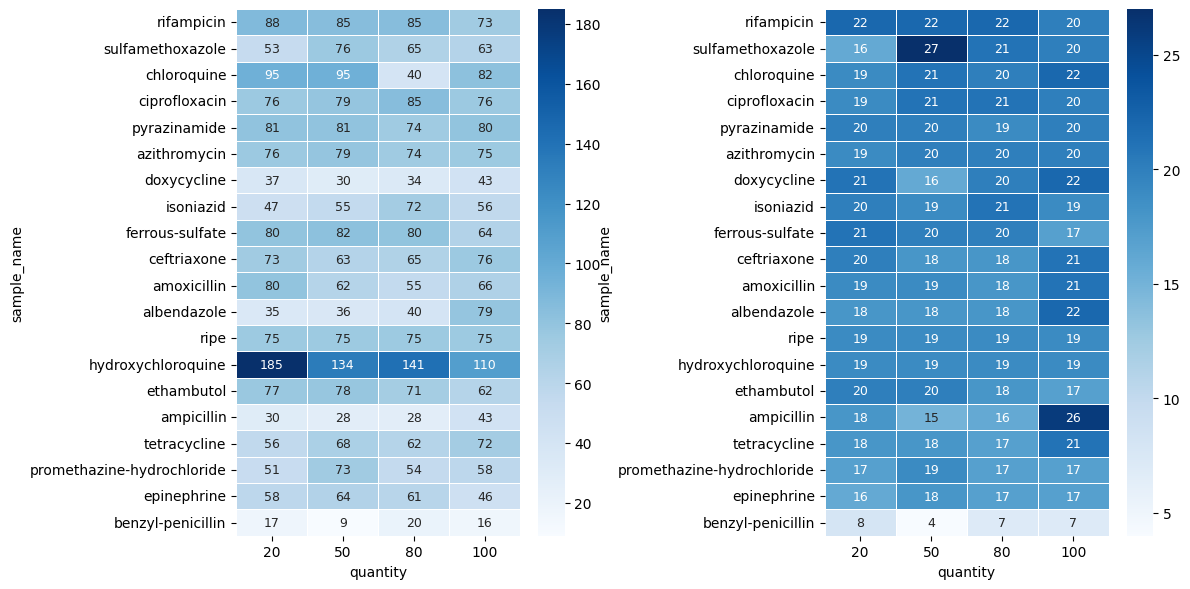

In [6]:
set_df = train
samples_unique = set_df[['sample_id','sample_name','quantity']].value_counts().reset_index(name='counts')
df1 = samples_unique[['sample_name','quantity']].value_counts().reset_index(name='counts')
df2 = set_df[['sample_name','quantity']].value_counts().reset_index(name='counts')

rows = "sample_name"
cols = "quantity"
values = "counts"

table1 = get_heatmap_table(df1, rows, cols, values, rows_order)
table2 = get_heatmap_table(df2, rows, cols, values, rows_order)
show_heatmap_tables(table2, table1, save_name= "./datasets/FHI2020_Stratified_Sampling/report/train_set_heatmap.png", figsize=(12, 6))

## Persist the splitting

In [10]:
train.to_csv('./datasets/FHI2020_Stratified_Sampling/train_set.csv', index=False)
val.to_csv('./datasets/FHI2020_Stratified_Sampling/val_set.csv', index=False)

## How to add this notebook to the DVC pipeline

*You only need to this set up once.*

You can add this notebook to the DVC pipeline by running the following command in the terminal:

```bash

dvc stage add \
-n run_notebook \
-d nbs/split_train_val_set.ipynb \
-d datasets/FHI2020_Stratified_Sampling/dev_set.csv \
-d datasets/FHI2020_Stratified_Sampling/images \
-o datasets/FHI2020_Stratified_Sampling/train_set.csv \
-o datasets/FHI2020_Stratified_Sampling/val_set.csv \
-o datasets/FHI2020_Stratified_Sampling/report/train_set_heatmap.png \
-o datasets/FHI2020_Stratified_Sampling/report/val_set_heatmap.png \
nbs/split_train_val_set.ipynb outputs/split_completed.ipynb -p VALIDATION_SIZE $(split_train_val.val_size) -p SEED  $(split_train_val.seed)

```

Note that the parameters `VALIDATION_SIZE` and `SEED` are passed to the notebook as arguments. \
The values of these parameters (`split_train_val.val_size` and `split_train_val.seed`) are defined in the `params.yaml` file.

 See the content of the `params.yaml` file below:
```yaml
split_train_val:
  val_size: 0.2
  seed: 42
  stratify: True
  
```
